# First pass calculation of the flux from mu decays

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt

# Local modules
import DarkNews as dn
from DarkNews import fourvec as fv
import MuC

## Test 1


Let's run a simple test to recover the muon decay at rest case. We set Emin and Emax to be essentially = to m_mu.

We should recover the Michel spectrum and a slightly less energetic nu_mubar component.

In [101]:
from MuC import mudecay_tools

p0, dpop = 0.01, 0.0001
theta0, dtheta = 0, 1e-5

kwargs = {
    'beam_p0': p0,
    'beam_dpop': dpop,
    'beam_theta0': theta0,
    'beam_dtheta': dtheta,
    'pmin': p0*(1-2*dpop),
    'pmax': p0*(1+2*dpop),
    'theta_min': 0,
    'theta_max': 2*dtheta,
    'NINT': 10,
    'NINT_warmup': 10,
    'NEVAL': 1e4,
    'NEVAL_warmup': 1e4,
}

dfs = []
Pols = np.linspace(0.2, 0.8, 10)

for p in Pols:
    mudecay_atrest = mudecay_tools.MuonDecay(save_mem=False)
    dfs.append(mudecay_atrest.simulate_decays(Rpm=p, **kwargs))

In [102]:
for i in range(10):
    print(dn.const.get_decay_rate_in_s(dfs[i].w_decay_rate.sum()))

0.2179220291352443
0.22148493172293607
0.22065601832700685
0.22201576460914518
0.2199910444359132
0.22128387275376768
0.2209632503714546
0.2233426087508003
0.22306846726807403
0.21841489264550457


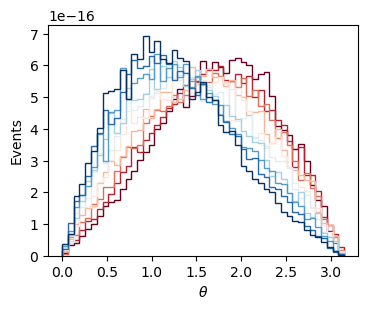

In [106]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=Pols.min(), vmax=Pols.max())
cmap = mpl.cm.RdBu
colors = cmap(np.linspace(0, 1, len(Pols)))

# num_bins = 50
num_bins = np.linspace(0, 3.15, 50)

fig, ax = plt.subplots(figsize=(4,3))

for i, df in enumerate(dfs):
    _ = ax.hist(np.arccos(fv.df_cos_azimuthal(df['P_decay_nu_mu'])), weights=df['w_flux'], bins=num_bins, density=False, histtype='step', lw=1, color=colors[i], label=rf'P={Pols[i]:.2f}')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'Events')
# ax.legend()
fig.savefig('plots/flux_histogram.png', dpi=300, bbox_inches='tight')

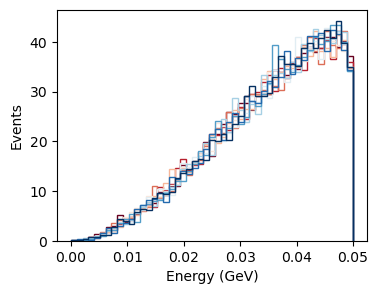

In [109]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=Pols.min(), vmax=Pols.max())
cmap = mpl.cm.RdBu
colors = cmap(np.linspace(0, 1, len(Pols)))

# num_bins = 50
num_bins = np.linspace(0, 0.05, 50)

fig, ax = plt.subplots(figsize=(4,3))

for i, df in enumerate(dfs):
    _ = ax.hist(df['P_decay_e','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color=colors[i], label=rf'P={Pols[i]:.2f}')

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(r'Events')
# ax.legend()
fig.savefig('plots/flux_histogram.png', dpi=300, bbox_inches='tight')


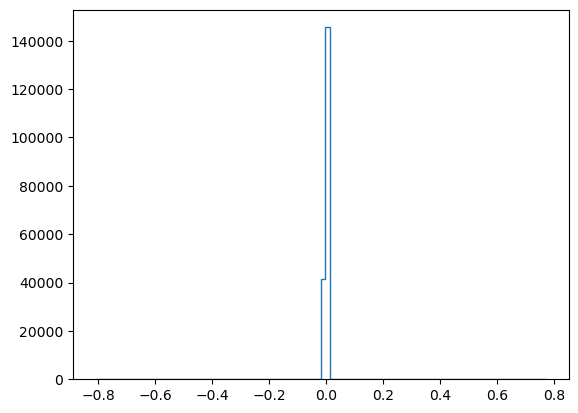

In [179]:
from DarkNews import Cfourvec as Cfv
P_mu = df['P_decay_mu'].to_numpy()
P_mu_afterrotation = Cfv.rotationx(P_mu, np.pi/2*np.ones(len(P_mu)))
_ = plt.hist(Cfv.get_cosTheta(P_mu_afterrotation), bins=100, histtype='step')

## Test 2

Now let's repeat it with a real muon beam

In [116]:
mudecay_beam = mudecay_tools.MuonDecay(save_mem=False)

# "beam_p0": 1e3,
# "pmax": 3e3,
# "pmin": ,
# "C": 3e5,
# "beam_dpop": ,
# "beam_dtheta": ,

df = mudecay_beam.simulate_decays(
                            pmin = 0,
                            pmax = 3e3,
                            beam_p0 = 1e5,
                            beam_dpop = 1e-3,
                            beam_dtheta=1.70e-4,
                            theta_min=0,
                            theta_max=0.1,
                            Rpm=0.5,
                            NINT=50,
                            NINT_warmup=50,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_beam.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_beam.flux_in_detector()

Detector acceptance: nan for nue and nan for numu
No flux in the detector


/Users/mhostert/Repos/BIN_MC-1/MuC/mudecay_tools.py:530: RuntimeWarning: invalid value encountered in scalar divide
  self.nue_eff_ND = np.sum(self.w[self.mask_nue]) / np.sum(self.w)
/Users/mhostert/Repos/BIN_MC-1/MuC/mudecay_tools.py:531: RuntimeWarning: invalid value encountered in scalar divide
  self.numu_eff_ND = np.sum(self.w[self.mask_numu]) / np.sum(self.w)


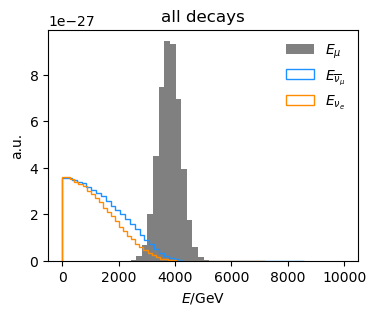

In [25]:
fig, ax = plt.subplots(figsize=(4,3))
fsize=12
n_bins = 50
ax.hist(mudecay_beam.Emu, weights=mudecay_beam.w, bins=n_bins, label=r'$E_\mu$',color='grey', histtype='stepfilled')
ax.hist(mudecay_beam.Enumu, weights=mudecay_beam.w, bins=n_bins, label=r'$E_{\overline{\nu}_\mu}$',color='dodgerblue', histtype='step')
ax.hist(mudecay_beam.Enue, weights=mudecay_beam.w, bins=n_bins, label=r'$E_{\nu_e}$',color='darkorange', histtype='step')

plt.legend(frameon=False,loc='upper right')
# ax.set_xlim(0,10)
ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$E/$GeV')
ax.set_title(r'all decays',fontsize=fsize)

fig.savefig('plots/true_flux.png', dpi=300, bbox_inches='tight')

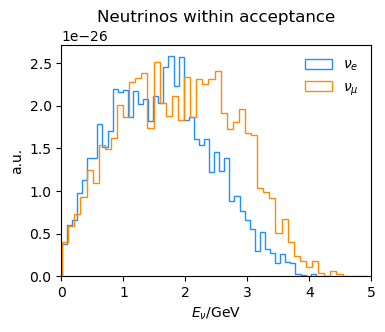

In [22]:
fig, ax = plt.subplots(figsize=(4,3))

n_bins = 50
ax.hist(mudecay_beam.Enue[mudecay_beam.mask_nue], weights=mudecay_beam.w[mudecay_beam.mask_nue], bins=n_bins, label=r'$\nu_e$',color='dodgerblue', histtype='step')
ax.hist(mudecay_beam.Enumu[mudecay_beam.mask_numu], weights=mudecay_beam.w[mudecay_beam.mask_numu], bins=n_bins, label=r'$\nu_\mu$',color='darkorange', histtype='step')

ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'Neutrinos within acceptance',fontsize=fsize)

fig.savefig('plots/nu_fluxes.png', dpi=300, bbox_inches='tight')

## get nu CC xsecs used in GLOBES

In [201]:
from scipy import interpolate

log10E,sigmae,sigmamu,_,sigmaebar,sigmamubar,_ = np.genfromtxt('xsecs/XCC.dat',unpack=True)
exs = 10**(log10E)
sigmanue = interpolate.interp1d(exs,sigmae*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanuebar = interpolate.interp1d(exs,sigmaebar*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumu = interpolate.interp1d(exs,sigmamu*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumubar = interpolate.interp1d(exs,sigmamubar*exs*1e-38,bounds_error=False,fill_value=0.0)

## Number of events

In [202]:
Detmass = 1e6 # g
Ntargets=dn.const.NAvo*Detmass
nevents_nue=mudecay_beam.flux_nue_ND*sigmanue(mudecay_beam.Enue_ND)*Ntargets/(mudecay_beam.Enue_ND[1]-mudecay_beam.Enue_ND[0])
nevents_numu=mudecay_beam.flux_numu_ND*sigmanumubar(mudecay_beam.Enumu_ND)*Ntargets/(mudecay_beam.Enumu_ND[1]-mudecay_beam.Enumu_ND[0])

In [203]:
# Event rate
Ntot_nue = np.sum(nevents_nue)
Ntot_numu = np.sum(nevents_numu)

print(Ntot_nue)
print(Ntot_numu)

6310757.390735747
2902466.266546023


# Fluxes

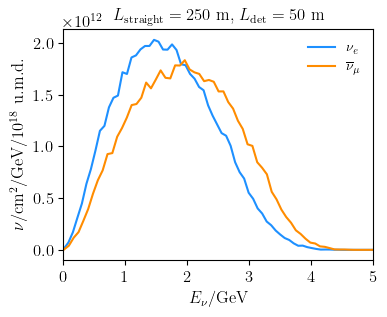

In [206]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(mudecay_beam.Enue_ND,mudecay_beam.flux_nue_ND,label=r'$\nu_e$',color='dodgerblue')
ax.plot(mudecay_beam.Enumu_ND,mudecay_beam.flux_numu_ND,label=r'$\overline{\nu}_\mu$',color='darkorange')

ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylabel(r'$\nu$/cm$^2$/GeV/$10^{18}$ u.m.d.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'$L_{\rm straight} = 250$~m, $L_{\rm det} = 50$~m ',fontsize=fsize)
# ax.set_yscale('log'),
# ax.set_ylim(1e9,1e12)
fig.savefig('plots/nu_fluxes_smooth.png', dpi=300, bbox_inches='tight')

# N events

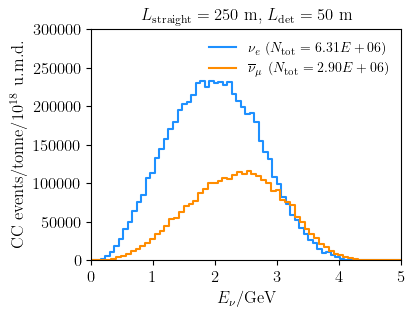

In [207]:
fig, ax = plt.subplots(figsize=(4,3))

ax.step(mudecay_beam.Enue_ND,nevents_nue,label=fr'$\nu_e$ ($N_{{\rm tot}} = {Ntot_nue:.2E}$)',color='dodgerblue')
ax.step(mudecay_beam.Enumu_ND,nevents_numu,label=fr'$\overline{{\nu}}_\mu$ ($N_{{\rm tot}} = {Ntot_numu:.2E}$)',color='darkorange')


ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylim(0,3e5)
ax.set_ylabel(r'CC events/tonne/$10^{18}$ u.m.d.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'$L_{\rm straight} = 250$~m, $L_{\rm det} = 50$~m ',fontsize=fsize)

fig.savefig('plots/nu_events.png', dpi=300, bbox_inches='tight')